# Semantic RAG Chunking Research: Advanced Mathematical Building Blocks
============================================================

**Retrieval Augmented Generation (RAG):** Describes the process of implementing semantic similarity processing into large language model context pipelines so that large language models are able to be systematically fed the most accurate, relevant information possible when prompted.

**Embeddings:** A mathematical representation of the semantic meaning of a particular phrase. Imagine an asterisk in 3D space, but with hundreds or thousands of points instead of just six. We use these mathematical representations of natural language phrases to compare between one another.

**Chunking:** The process by which we separate documents into groups of sentences (chunks) based on semantic similarity. Think of breaking up a document into "paragraphs."

This notebook demonstrates novel, advanced semantic chunking algorithms developed through extensive research into mathematical optimization techniques for Retrieval Augmented Generation (RAG) systems. All research was conducted on the now-depreciated Chunking Subnet within the Bittensor ecosystem; an extremely competitve, decentralized network of incentivized miners that compete to solve problems. 

## Table of Contents:
1. Foundation - Understanding the Problem
2. Building Block 1 - Similarity Matrices
3. Building Block 2 - Distance Calculations
4. Building Block 3 - Dynamic Programming Framework
5. Building Block 4 - Advanced Optimization Tools
6. The Five Methods - Combining Building Blocks
7. Comparative Analysis and Validation

## 1.0 Foundation - Understanding the Problem

When we use natural language processing to talk to LLM's, we need to ensure we give them semantically relevant, accurate information. We also want to make sure we don't give them *too* much information as well. This is why we build RAG systems that allow us to retrieve relevant information so that a model can give an accurate output based on the user's input prompt.

Let's say a user talks to an LLM about a question inside a document. A typical LLM pipeline might look like this:

0. Prior to any user interaction, the document would be chunked according to semantic similarity, and these chunks of text would be stored in a "vector store" for retrieval upon prompting (explained later).
1. User inputs a prompt into an LLM.
2. User's prompt is first directly fed to an embedding model.
3. Embedding is sent to the vector store service that hosts the document's text and embeddings, almost like a "library lookup" for relevant text.
4. Most semantically relevant text from the document is returned back to the model as additional context, along with the original text prompt.
5. LLM is able to answer the question accurately and reliably without becoming overloaded.

## 1.1 Chunking, Solved Through Bittensor

How would you separate a Harry Potter article into paragraphs, without having the indentations? What about a phone book, or an excel spreadsheet full of medical records? What about a long series of emails across multiple topics? This is the core problem of chunking; it's arguably infinitely complex. Not because humans can't do it, but because there's technically no right or wrong answer. Chunking heavily depends on the use-case of the documents being chunked.

Enter Bittensor; a network of engineers being incentivized to solve impossible problems. From 2024-2025, the subnet known as Chunking, set out to solve this exact problem, with its own reward structure and heuristic for doing so. The research described in this notebook was discovered via this specific reward heuristic, which will be demonstrated.

## 1.2 What Does Good Chunking Look Like?

In [20]:
# Let's start with a simple example
sample_text = """
Harry Potter was a young wizard who lived with his aunt and uncle. 
He had messy black hair and wore round glasses.
Hogwarts School of Witchcraft and Wizardry was his home.
The climate change crisis threatens our planet's future.
Rising sea levels endanger coastal communities worldwide.
"""

# If we chunk this manually, we'd probably group:
# Chunk 1: Sentences about Harry Potter (1, 2, 3)
# Chunk 2: Sentences about climate change (4, 5)s

# Manual chunking makes sense because:
# 1. Harry Potter sentences are similar to each other
# 2. Climate sentences are similar to each other
# 3. But Harry Potter sentences are DIFFERENT from climate sentences.

But how do we teach a computer to understand "similarity" to begin with? This is where **vector embeddings** come in.
Think of embeddings as a way to translate sentences into mathematical coordinates.

In the following example, you'll be able to actually **see** vector embeddings in 3D space. Feel free to change the sentences in Step 2 however you'd like as well to experiment!

🤖 Loading SentenceTransformer model...
✅ Model loaded! This creates 384-dimensional vectors for each sentence.

🧮 Computing real embeddings...
✅ Got embeddings! Shape: (5, 384)
   → Each sentence is now a 384-dimensional vector

📊 Raw embedding samples (first 10 dimensions):
Sentence 1: 'Harry Potter was a young wizard...'
First 10 dims: [ 0.004  0.079 -0.044  0.028 -0.075  0.003  0.023 -0.006 -0.043 -0.038]

Sentence 2: 'He wore round glasses...'
First 10 dims: [ 0.037  0.109 -0.036 -0.014 -0.003 -0.033  0.122  0.043 -0.045  0.022]

Sentence 3: 'Hogwarts School of Witchcraft and W...'
First 10 dims: [ 0.059  0.076 -0.052  0.025 -0.051 -0.018  0.039 -0.044 -0.106 -0.056]

Sentence 4: 'Climate change threatens our planet...'
First 10 dims: [-0.007  0.088  0.11   0.062  0.127  0.054 -0.066 -0.01   0.041  0.044]

Sentence 5: 'Rising sea levels are dangerous...'
First 10 dims: [-0.019  0.01   0.067  0.019  0.023  0.038 -0.07   0.032 -0.068  0.001]

🔄 Reducing 384 dimensions → 3 dimensions 

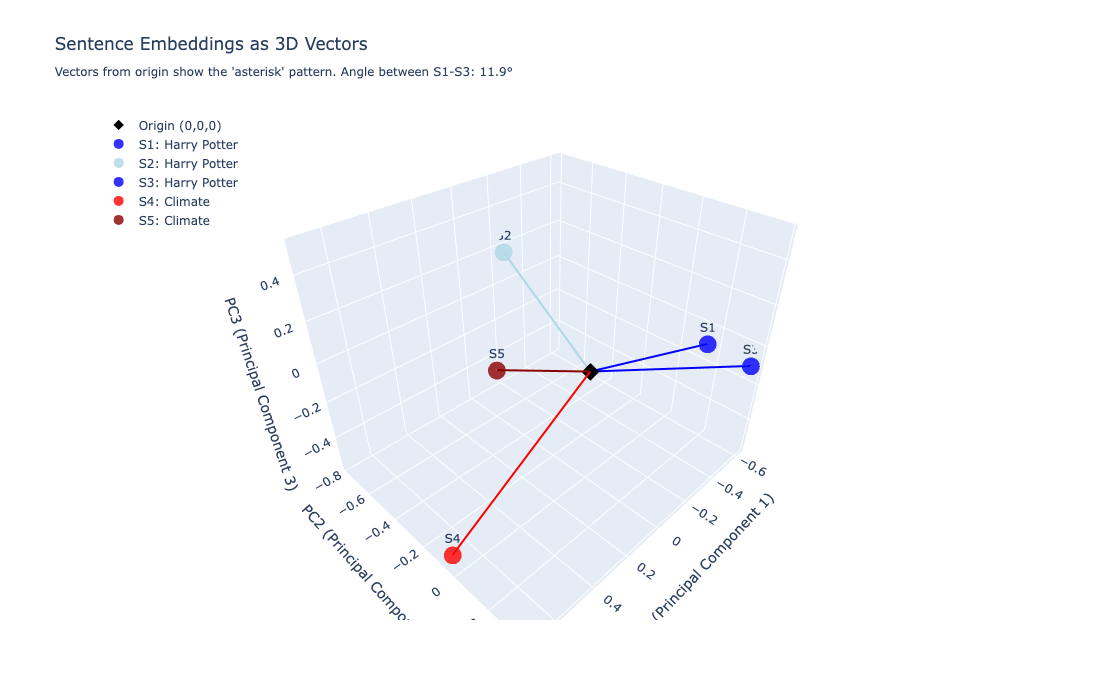

📍 3D Coordinates:
S1: [-0.537,  0.198, -0.028] - 'Harry Potter was a young wizard...'
S2: [-0.246, -0.780,  0.172] - 'He wore round glasses...'
S3: [-0.616,  0.374, -0.096] - 'Hogwarts School of Witchcraft and Wizard...'
S4: [ 0.697, -0.065, -0.559] - 'Climate change threatens our planet...'
S5: [ 0.701,  0.272,  0.510] - 'Rising sea levels are dangerous...'

🎯 Key Observations from the Vector Visualization:
   • Each sentence is a VECTOR (arrow) from the origin to its point
   • Harry Potter vectors (S1, S2, S3) point in similar directions
   • Climate vectors (S4, S5) point in a similar direction to each other
   • But Harry Potter and Climate vectors point in VERY different directions!
   • The ANGLE between vectors determines similarity (not distance)
   • Small angle = high similarity, large angle = low similarity

💡 This 'asterisk' pattern is why it's called 'vector' embeddings!
   Each sentence becomes an arrow pointing in semantic space.


In [1]:
import numpy as np
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

def real_embedding_demo():
    """
    REAL demonstration of how embeddings work using actual AI models!
    We'll use MiniLM to get actual 384-dimensional embeddings, then visualize in 3D.
    """
    
    # Step 1: Load a real embedding model
    print("🤖 Loading SentenceTransformer model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')  # 384 dimensions
    print("✅ Model loaded! This creates 384-dimensional vectors for each sentence.")
    print()
    
    # Step 2: Our sample sentences (same as before)
    sentences = [
        "Harry Potter was a young wizard",
        "He wore round glasses", 
        "Hogwarts School of Witchcraft and Wizardry was his home",
        "Climate change threatens our planet",
        "Rising sea levels are dangerous"
    ]
    
    # Step 3: Get REAL embeddings from the model
    print("🧮 Computing real embeddings...")
    embeddings = model.encode(sentences)
    print(f"✅ Got embeddings! Shape: {embeddings.shape}")
    print(f"   → Each sentence is now a {embeddings.shape[1]}-dimensional vector")
    print()
    
    # Step 4: Show what the raw embeddings look like
    print("📊 Raw embedding samples (first 10 dimensions):")
    print("=" * 55)
    for i, (sentence, embedding) in enumerate(zip(sentences, embeddings)):
        print(f"Sentence {i+1}: '{sentence[:35]}...'")
        print(f"First 10 dims: {embedding[:10].round(3)}")
        print()
    
    # Step 5: Reduce to 3D for visualization using PCA
    print("🔄 Reducing 384 dimensions → 3 dimensions for visualization...")
    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(embeddings)
    
    # Show how much information we retain in 3D
    explained_variance = pca.explained_variance_ratio_.sum()
    print(f"✅ 3D visualization captures {explained_variance:.1%} of the original information")
    print()
    
    # Step 6: Create interactive 3D visualization showing vectors from origin
    print("🎨 Creating 3D vector visualization (the 'asterisk' pattern)...")
    
    # Color code by topic: Harry Potter (blue) vs Climate (red)
    colors = ['blue', 'lightblue', 'blue', 'red', 'darkred']
    topics = ['Harry Potter', 'Harry Potter', 'Harry Potter', 'Climate', 'Climate']
    
    fig = go.Figure()
    
    # Add the origin point (0,0,0)
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        marker=dict(size=8, color='black', symbol='diamond'),
        name='Origin (0,0,0)',
        showlegend=True
    ))
    
    # Add vectors (arrows) from origin to each sentence embedding
    for i, (coords, color, topic, sentence) in enumerate(zip(embeddings_3d, colors, topics, sentences)):
        # Add the endpoint (sentence position)
        fig.add_trace(go.Scatter3d(
            x=[coords[0]], 
            y=[coords[1]], 
            z=[coords[2]],
            mode='markers+text',
            marker=dict(size=10, color=color, opacity=0.8),
            text=[f"S{i+1}"],
            textposition="top center",
            name=f"S{i+1}: {topic}",
            hovertemplate=f"<b>Sentence {i+1}</b><br>" +
                         f"{topic}<br>" +
                         f"'{sentence[:50]}...'<br>" +
                         f"Vector: [{coords[0]:.3f}, {coords[1]:.3f}, {coords[2]:.3f}]<br>" +
                         "<extra></extra>",
            showlegend=True
        ))
        
        # Add the vector line from origin to sentence
        fig.add_trace(go.Scatter3d(
            x=[0, coords[0]], 
            y=[0, coords[1]], 
            z=[0, coords[2]],
            mode='lines',
            line=dict(color=color, width=4),
            name=f"Vector S{i+1}",
            showlegend=False,  # Don't clutter legend with vector lines
            hoverinfo='skip'
        ))
    
    # Add angle visualization between similar vectors (optional enhancement)
    # Let's show the angle between S1 and S3 (both Harry Potter)
    s1_coords = embeddings_3d[0]
    s3_coords = embeddings_3d[2]
    
    # Calculate the angle between vectors for display
    dot_product = np.dot(s1_coords, s3_coords)
    magnitude1 = np.linalg.norm(s1_coords)
    magnitude3 = np.linalg.norm(s3_coords)
    angle_radians = np.arccos(np.clip(dot_product / (magnitude1 * magnitude3), -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)
    
    fig.update_layout(
        title=f"Sentence Embeddings as 3D Vectors<br><sub>Vectors from origin show the 'asterisk' pattern. Angle between S1-S3: {angle_degrees:.1f}°</sub>",
        scene=dict(
            xaxis_title="PC1 (Principal Component 1)",
            yaxis_title="PC2 (Principal Component 2)", 
            zaxis_title="PC3 (Principal Component 3)",
            camera=dict(eye=dict(x=1.2, y=1.2, z=1.2)),
            # Make sure we can see the origin clearly
            xaxis=dict(showspikes=True, spikecolor="black", spikethickness=2),
            yaxis=dict(showspikes=True, spikecolor="black", spikethickness=2),
            zaxis=dict(showspikes=True, spikecolor="black", spikethickness=2)
        ),
        width=900,
        height=700,
        legend=dict(x=0.02, y=0.98)
    )
    
    fig.show()
    
    # Step 7: Print the 3D coordinates for reference
    print("📍 3D Coordinates:")
    print("=" * 20)
    for i, (sentence, coords) in enumerate(zip(sentences, embeddings_3d)):
        print(f"S{i+1}: [{coords[0]:6.3f}, {coords[1]:6.3f}, {coords[2]:6.3f}] - '{sentence[:40]}...'")
    
    print("\n🎯 Key Observations from the Vector Visualization:")
    print("   • Each sentence is a VECTOR (arrow) from the origin to its point")
    print("   • Harry Potter vectors (S1, S2, S3) point in similar directions")
    print("   • Climate vectors (S4, S5) point in a similar direction to each other") 
    print("   • But Harry Potter and Climate vectors point in VERY different directions!")
    print("   • The ANGLE between vectors determines similarity (not distance)")
    print(f"   • Small angle = high similarity, large angle = low similarity")
    print()
    print("💡 This 'asterisk' pattern is why it's called 'vector' embeddings!")
    print("   Each sentence becomes an arrow pointing in semantic space.")
    
    return sentences, embeddings, embeddings_3d

# Run the demo
sentences, embeddings, embeddings_3d = real_embedding_demo()

Knowing this, we can mathematically compare sentences by calculating **dot product similarity** between their dimensions:

>>> Demonstrating Dot Product Similarity in 3D Space
Sentence A: 'Harry Potter was a young wizard'
Sentence B: 'Climate change threatens our planet'

Getting embeddings for both sentences...
Original embeddings shape: (3, 384)
3D coordinates for visualization:
  Vector A: [-0.579,  0.556, -0.000]
  Vector B: [ 0.823,  0.175, -0.000]

Mathematical Breakdown:
  Dot Product: -0.055
  Vector A magnitude: 1.000
  Vector B magnitude: 1.000
  Normalized value (for angle): -0.055
  Angle between vectors: 93.1°



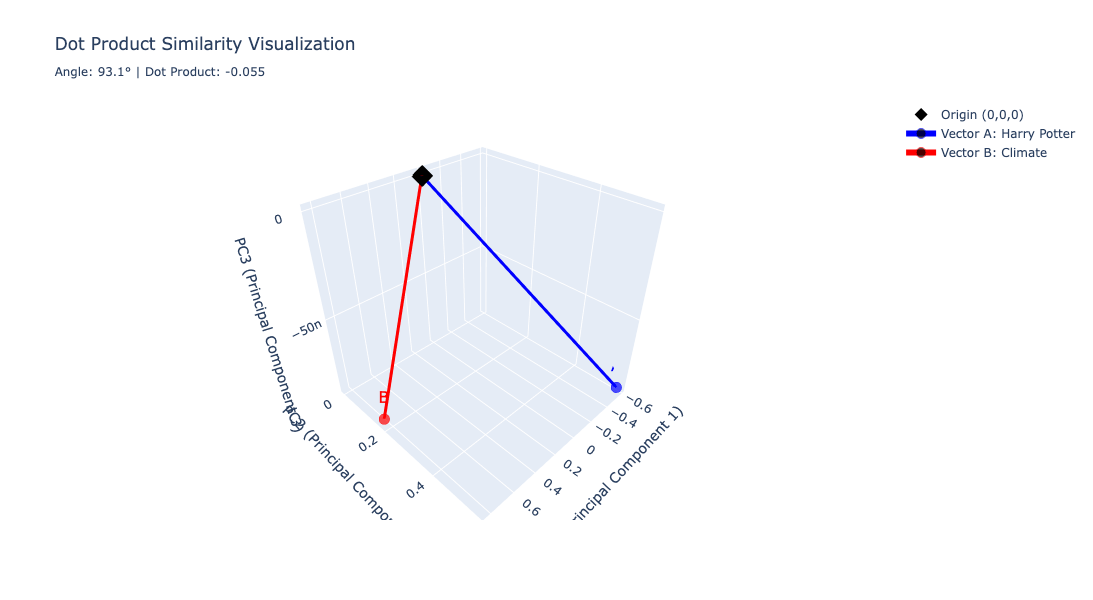

Understanding the Results:
  • The dot product between vectors is -0.055
  • This includes BOTH the angle (93.1°) AND the vector magnitudes
  • Dot product = ||A|| × ||B|| × cos(angle) = 1.000 × 1.000 × -0.055
  • This -0.055 value is EXACTLY what goes into similarity matrices!

Interpretation: LOW dot product - vectors point in different directions or have small magnitudes

Key Insight:
   Dot product is DIFFERENT from normalized similarity because it includes
   vector magnitudes. Longer vectors (richer semantic content) get higher scores
   even at the same angle. This is why Bittensor used dot product!


In [5]:
import numpy as np
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

def visualize_dot_product_similarity_in_3d():
    """
    Demonstrate dot product similarity between two sentences using 3D visualization.
    This shows EXACTLY what goes into our similarity matrices!
    """
    
    print(">>> Demonstrating Dot Product Similarity in 3D Space")
    print("=" * 50)
    
    # Load the model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Step 1: Choose two contrasting sentences
    sentence_a = "Harry Potter was a young wizard"
    sentence_b = "Climate change threatens our planet"
    
    print(f"Sentence A: '{sentence_a}'")
    print(f"Sentence B: '{sentence_b}'")
    print()
    
    # Step 2: Get real embeddings (add neutral sentence for PCA to work in 3D)
    print("Getting embeddings for both sentences...")
    # Add a neutral sentence just for PCA dimensionality (we'll only visualize A and B)
    sentences_for_pca = [sentence_a, sentence_b, "This is a neutral sentence."]
    embeddings_with_neutral = model.encode(sentences_for_pca)
    print(f"Original embeddings shape: {embeddings_with_neutral.shape}")
    
    # Step 3: Reduce to 3D for visualization
    pca_reducer = PCA(n_components=3)
    embeddings_3d = pca_reducer.fit_transform(embeddings_with_neutral)
    
    vec_a_3d = embeddings_3d[0]  # Harry Potter vector in 3D
    vec_b_3d = embeddings_3d[1]  # Climate vector in 3D
    # We'll ignore the neutral sentence vector for visualization
    
    print(f"3D coordinates for visualization:")
    print(f"  Vector A: [{vec_a_3d[0]:6.3f}, {vec_a_3d[1]:6.3f}, {vec_a_3d[2]:6.3f}]")
    print(f"  Vector B: [{vec_b_3d[0]:6.3f}, {vec_b_3d[1]:6.3f}, {vec_b_3d[2]:6.3f}]")
    print()
    
    # Step 4: Calculate dot product similarity using the original high-dimensional embeddings
    def calculate_dot_product_similarity(vec1, vec2):
        """Calculate dot product similarity - this is what Bittensor uses!"""
        return np.dot(vec1, vec2)
    
    # Use original high-dimensional embeddings for accurate dot product
    embeddings_original = model.encode([sentence_a, sentence_b])  # Just the two main sentences
    dot_product_value = calculate_dot_product_similarity(embeddings_original[0], embeddings_original[1])
    
    # Calculate vector magnitudes for educational purposes
    magnitude_a = np.linalg.norm(embeddings_original[0])
    magnitude_b = np.linalg.norm(embeddings_original[1])
    
    # Calculate the angle for educational purposes (dot product = ||a|| * ||b|| * cos(angle))
    normalized_dot_product = dot_product_value / (magnitude_a * magnitude_b)
    angle_radians = np.arccos(np.clip(normalized_dot_product, -1.0, 1.0))
    angle_degrees = np.degrees(angle_radians)
    
    print(f"Mathematical Breakdown:")
    print(f"  Dot Product: {dot_product_value:.3f}")
    print(f"  Vector A magnitude: {magnitude_a:.3f}")
    print(f"  Vector B magnitude: {magnitude_b:.3f}")
    print(f"  Normalized value (for angle): {normalized_dot_product:.3f}")
    print(f"  Angle between vectors: {angle_degrees:.1f}°")
    print()
    
    # Step 5: Create 3D visualization showing the vectors and dot product
    fig = go.Figure()
    
    # Add origin
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        marker=dict(size=10, color='black', symbol='diamond'),
        name='Origin (0,0,0)',
    ))
    
    # Add Vector A (Harry Potter)
    fig.add_trace(go.Scatter3d(
        x=[0, vec_a_3d[0]], y=[0, vec_a_3d[1]], z=[0, vec_a_3d[2]],
        mode='lines+markers',
        line=dict(color='blue', width=6),
        marker=dict(size=[8, 12], color=['black', 'blue']),
        name=f'Vector A: Harry Potter',
        hovertemplate=f"<b>Harry Potter Vector</b><br>" +
                     f"Sentence: '{sentence_a}'<br>" +
                     f"3D Endpoint: [{vec_a_3d[0]:.3f}, {vec_a_3d[1]:.3f}, {vec_a_3d[2]:.3f}]<br>" +
                     f"Original Magnitude: {magnitude_a:.3f}<br>" +
                     "<extra></extra>"
    ))
    
    # Add Vector B (Climate)
    fig.add_trace(go.Scatter3d(
        x=[0, vec_b_3d[0]], y=[0, vec_b_3d[1]], z=[0, vec_b_3d[2]],
        mode='lines+markers',
        line=dict(color='red', width=6),
        marker=dict(size=[8, 12], color=['black', 'red']),
        name=f'Vector B: Climate',
        hovertemplate=f"<b>Climate Vector</b><br>" +
                     f"Sentence: '{sentence_b}'<br>" +
                     f"3D Endpoint: [{vec_b_3d[0]:.3f}, {vec_b_3d[1]:.3f}, {vec_b_3d[2]:.3f}]<br>" +
                     f"Original Magnitude: {magnitude_b:.3f}<br>" +
                     "<extra></extra>"
    ))
    
    # Add text annotations at the vector endpoints
    fig.add_trace(go.Scatter3d(
        x=[vec_a_3d[0], vec_b_3d[0]], 
        y=[vec_a_3d[1], vec_b_3d[1]], 
        z=[vec_a_3d[2], vec_b_3d[2]],
        mode='text',
        text=['A', 'B'],
        textfont=dict(size=16, color=['blue', 'red']),
        textposition="top center",
        showlegend=False,
        hoverinfo='skip'
    ))
    
    fig.update_layout(
        title=f"Dot Product Similarity Visualization<br>" +
              f"<sub>Angle: {angle_degrees:.1f}° | Dot Product: {dot_product_value:.3f}</sub>",
        scene=dict(
            xaxis_title="PC1 (Principal Component 1)",
            yaxis_title="PC2 (Principal Component 2)", 
            zaxis_title="PC3 (Principal Component 3)",
            camera=dict(eye=dict(x=1.3, y=1.3, z=1.3)),
            aspectmode='cube'  # Make it easier to see angles
        ),
        width=800,
        height=600
    )
    
    fig.show()
    
    # Step 6: Explain the results
    print("Understanding the Results:")
    print(f"  • The dot product between vectors is {dot_product_value:.3f}")
    print(f"  • This includes BOTH the angle ({angle_degrees:.1f}°) AND the vector magnitudes")
    print(f"  • Dot product = ||A|| × ||B|| × cos(angle) = {magnitude_a:.3f} × {magnitude_b:.3f} × {normalized_dot_product:.3f}")
    print(f"  • This {dot_product_value:.3f} value is EXACTLY what goes into similarity matrices!")
    print()
    
    if dot_product_value > 50:
        interpretation = "HIGH dot product - vectors have strong alignment and good magnitudes"
    elif dot_product_value > 10:
        interpretation = "MEDIUM dot product - some alignment but moderate magnitudes or angles"
    else:
        interpretation = "LOW dot product - vectors point in different directions or have small magnitudes"
    
    print(f"Interpretation: {interpretation}")
    print()
    print("Key Insight:")
    print("   Dot product is DIFFERENT from normalized similarity because it includes")
    print("   vector magnitudes. Longer vectors (richer semantic content) get higher scores")
    print("   even at the same angle. This is why Bittensor used dot product!")
    
    return dot_product_value, angle_degrees

# Run the demonstration
similarity_score, angle = visualize_dot_product_similarity_in_3d()

## 2.0 Reward Heuristic: Finding The "Best" Chunks

Going back to Harry Potter, imagine we could somehow calculate the similarity between sentences within the same paragraph. Ideally, they should be very similar. Now imagine we could calculate the similarity between random sentences from different paragraphs. Ideally, despite being random, they would be *more dissimilar than similar*.

The Bittensor Chunking subnet used a mathematical way to measure chunk quality. Now that we understand cosine similarity, let's see how this reward system works:

>>> Bittensor Reward Heuristic Visualization
>>> Calculating all pairwise dot products...
   (This is the math the Bittensor reward heuristic uses)



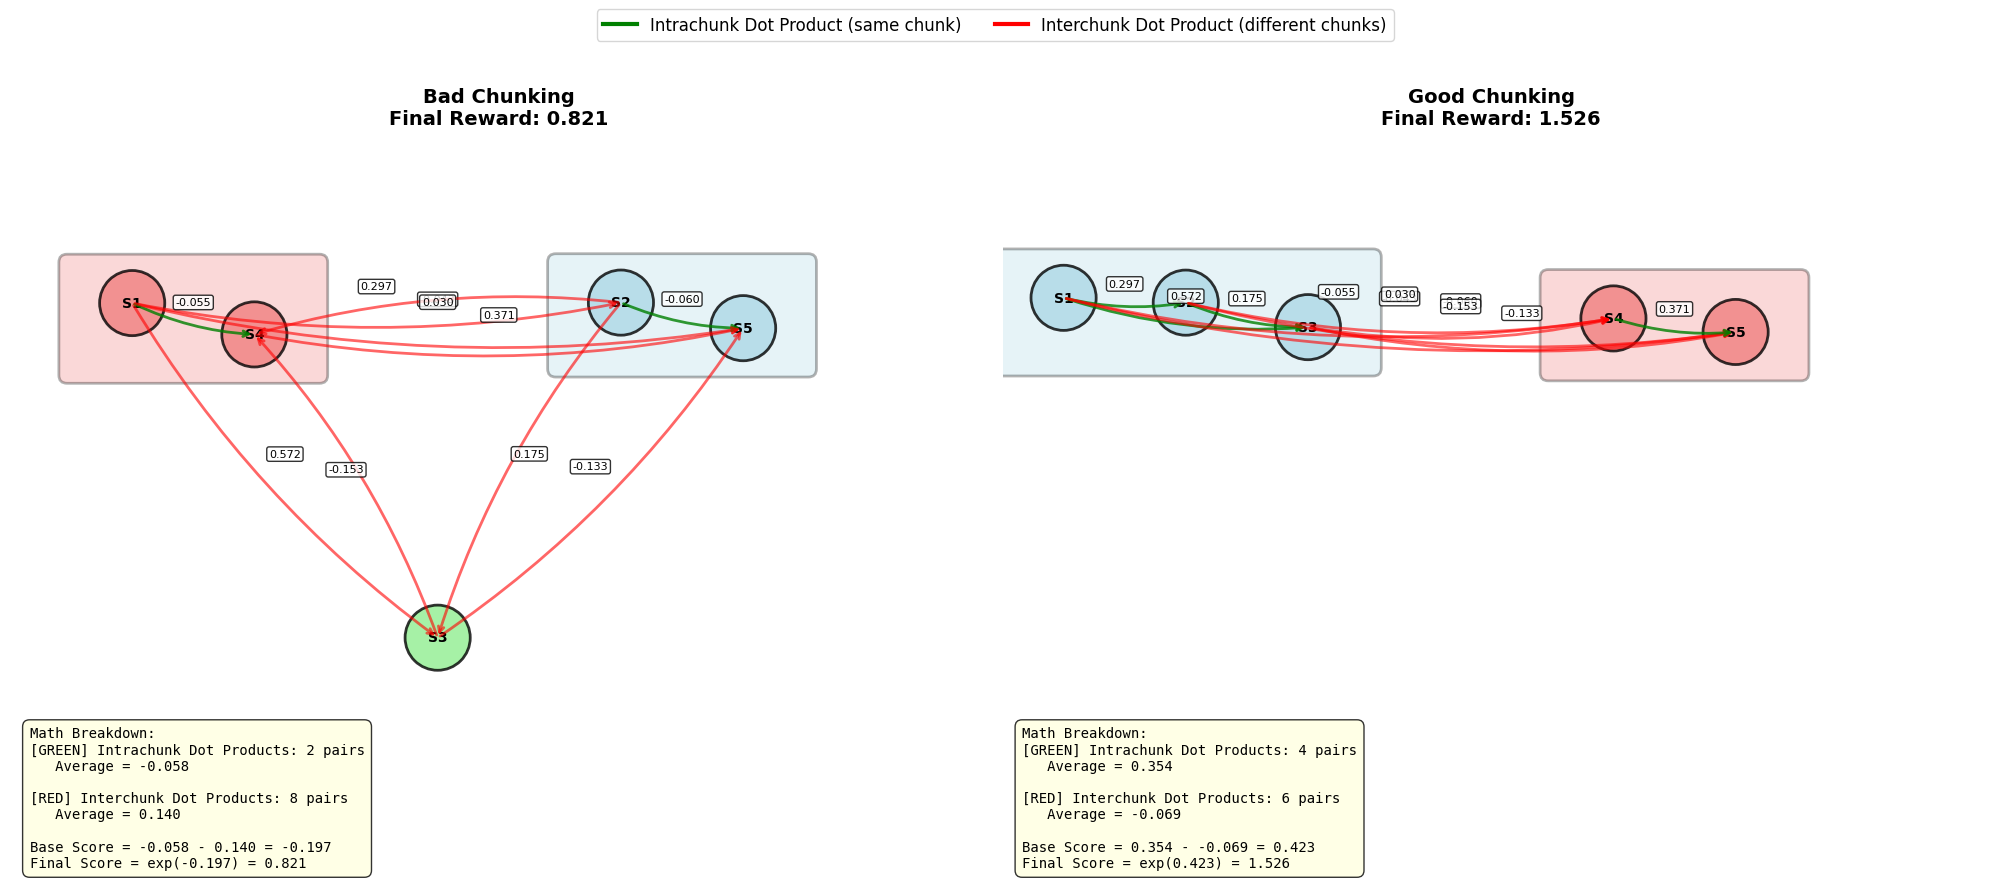

>>> Key Insights:
   • ALL sentence pairs get dot product calculations (10 total for 5 sentences)
   • Green arrows = Intrachunk dot products (want these HIGH)
   • Red arrows = Interchunk dot products (want these LOW)
   • Good chunking maximizes: exp(High Intra - Low Inter)
   • Exponential scoring makes small improvements MUCH more significant!

>>> Scaling Up:
   • For 100 sentences: 4,950 pairwise calculations!
   • For 1000 sentences: 499,500 calculations!
   • This is why we need efficient similarity matrices...


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch
import numpy as np

def visualize_reward_heuristic():
    """
    Visualize the Bittensor reward heuristic calculation using a flowchart-style diagram.
    Shows all pairwise similarities and the math that produces ~1.05 scores.
    """
    
    print(">>> Bittensor Reward Heuristic Visualization")
    print("=" * 45)

    model = SentenceTransformer('all-MiniLM-L6-v2')  # 384 dimensions

    # Our 5 sentences (same as before)
    sentences = [
        "Harry Potter was a young wizard",
        "He wore round glasses", 
        "Hogwarts School of Witchcraft and Wizardry was his home",
        "Climate change threatens our planet",
        "Rising sea levels are dangerous"
    ]
    
    # Get real embeddings and calculate all pairwise dot products
    embeddings = model.encode(sentences)
    
    # Calculate dot product similarity matrix (this is what Bittensor actually uses!)
    similarities = np.dot(embeddings, embeddings.T)
    
    print(">>> Calculating all pairwise dot products...")
    print("   (This is the math the Bittensor reward heuristic uses)")
    print()
    
    # Define two chunking strategies to compare
    strategies = {
        "Bad Chunking": {
            "chunks": [[0, 3], [1, 4], [2]],  # Mixed topics
            "colors": ["lightcoral", "lightblue", "lightgreen"]
        },
        "Good Chunking": {
            "chunks": [[0, 1, 2], [3, 4]],  # Topic-based
            "colors": ["lightblue", "lightcoral"]
        }
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    for idx, (strategy_name, strategy) in enumerate(strategies.items()):
        ax = ax1 if idx == 0 else ax2
        
        # Position sentences in 2D space grouped by chunks
        positions = []
        chunk_centers = [(2, 7), (8, 7), (5, 3)]  # Different positions for up to 3 chunks
        
        for chunk_idx, chunk in enumerate(strategy["chunks"]):
            center_x, center_y = chunk_centers[chunk_idx]
            for i, sent_idx in enumerate(chunk):
                # Position sentences around chunk center
                x = center_x + (i - len(chunk)/2) * 1.5
                y = center_y + np.random.uniform(-0.3, 0.3)  # Small random offset
                positions.append((x, y))
        
        # Reorder positions to match original sentence order
        ordered_positions = [None] * 5
        position_idx = 0
        for chunk in strategy["chunks"]:
            for sent_idx in chunk:
                ordered_positions[sent_idx] = positions[position_idx]
                position_idx += 1
        positions = ordered_positions
        
        # Draw chunk boundary boxes
        for chunk_idx, chunk in enumerate(strategy["chunks"]):
            if len(chunk) > 1:
                chunk_positions = [positions[i] for i in chunk]
                min_x = min(pos[0] for pos in chunk_positions) - 0.8
                max_x = max(pos[0] for pos in chunk_positions) + 0.8
                min_y = min(pos[1] for pos in chunk_positions) - 0.5
                max_y = max(pos[1] for pos in chunk_positions) + 0.5
                
                rect = FancyBboxPatch(
                    (min_x, min_y), max_x - min_x, max_y - min_y,
                    boxstyle="round,pad=0.1",
                    facecolor=strategy["colors"][chunk_idx],
                    alpha=0.3,
                    edgecolor='black',
                    linewidth=2
                )
                ax.add_patch(rect)
        
        # Draw sentences as circles
        for i, (x, y) in enumerate(positions):
            # Determine which chunk this sentence belongs to
            chunk_color = 'gray'
            for chunk_idx, chunk in enumerate(strategy["chunks"]):
                if i in chunk:
                    chunk_color = strategy["colors"][chunk_idx]
                    break
            
            circle = plt.Circle((x, y), 0.4, facecolor=chunk_color, alpha=0.8, edgecolor='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(x, y, f'S{i+1}', ha='center', va='center', fontweight='bold', fontsize=10)
        
        # Calculate intrachunk and interchunk similarities for this strategy
        intrachunk_similarities = []
        interchunk_similarities = []
        
        # Draw arrows for all pairwise dot products
        for i in range(5):
            for j in range(i + 1, 5):
                dot_product = similarities[i, j]
                
                # Determine if this pair is intrachunk or interchunk
                same_chunk = False
                for chunk in strategy["chunks"]:
                    if i in chunk and j in chunk:
                        same_chunk = True
                        intrachunk_similarities.append(dot_product)
                        break
                
                if not same_chunk:
                    interchunk_similarities.append(dot_product)
                
                # Draw arrow
                x1, y1 = positions[i]
                x2, y2 = positions[j]
                
                # Arrow color: green for intrachunk, red for interchunk
                arrow_color = 'green' if same_chunk else 'red'
                alpha = 0.8 if same_chunk else 0.6
                
                # Draw curved arrow to avoid overlap
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                
                ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                           arrowprops=dict(arrowstyle='->', color=arrow_color, 
                                         alpha=alpha, lw=2, connectionstyle="arc3,rad=0.1"))
                
                # Add dot product value on arrow
                ax.text(mid_x, mid_y + 0.2, f'{dot_product:.3f}', 
                       ha='center', va='center', fontsize=8, 
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
        
        # Calculate reward score with exponential scaling (like Bittensor)
        avg_intra = np.mean(intrachunk_similarities) if intrachunk_similarities else 0
        avg_inter = np.mean(interchunk_similarities) if interchunk_similarities else 0
        base_reward = avg_intra - avg_inter
        
        # Apply exponential scoring (this is the key Bittensor innovation!)
        final_reward = np.exp(base_reward)
        
        # Add title and math
        ax.set_title(f'{strategy_name}\nFinal Reward: {final_reward:.3f}', 
                    fontsize=14, fontweight='bold', pad=20)
        
        # Add math breakdown at bottom
        math_text = f"""Math Breakdown:
[GREEN] Intrachunk Dot Products: {len(intrachunk_similarities)} pairs
   Average = {avg_intra:.3f}

[RED] Interchunk Dot Products: {len(interchunk_similarities)} pairs  
   Average = {avg_inter:.3f}

Base Score = {avg_intra:.3f} - {avg_inter:.3f} = {base_reward:.3f}
Final Score = exp({base_reward:.3f}) = {final_reward:.3f}"""
        
        ax.text(0.02, 0.02, math_text, transform=ax.transAxes, fontsize=10,
               verticalalignment='bottom', fontfamily='monospace',
               bbox=dict(boxstyle="round,pad=0.5", facecolor='lightyellow', alpha=0.8))
        
        # Set axis properties
        ax.set_xlim(-1, 11)
        ax.set_ylim(0, 9)
        ax.set_aspect('equal')
        ax.axis('off')
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=3, label='Intrachunk Dot Product (same chunk)'),
        plt.Line2D([0], [0], color='red', lw=3, label='Interchunk Dot Product (different chunks)')
    ]
    fig.legend(handles=legend_elements, loc='upper center', ncol=2, fontsize=12, 
              bbox_to_anchor=(0.5, 0.95))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    print(">>> Key Insights:")
    print("   • ALL sentence pairs get dot product calculations (10 total for 5 sentences)")
    print("   • Green arrows = Intrachunk dot products (want these HIGH)")
    print("   • Red arrows = Interchunk dot products (want these LOW)") 
    print("   • Good chunking maximizes: exp(High Intra - Low Inter)")
    print("   • Exponential scoring makes small improvements MUCH more significant!")
    print()
    print(">>> Scaling Up:")
    print("   • For 100 sentences: 4,950 pairwise calculations!")
    print("   • For 1000 sentences: 499,500 calculations!")
    print("   • This is why we need efficient similarity matrices...")

# Run the visualization
visualize_reward_heuristic()

This method of scoring chunks was applied to fully chunked documents, typically resulted in a score near `1.0`, using the `text-embedding-ada-002` model from OpenAI. Crucially, the subnet required all chunks in the document to be within a max chunk size and chunk quantity. By maximizing the difference between intrachunk and interchunk similarity across many random samples, while staying within a max chunk size and max chunk quantity, algorithms highly optimized for this heuristic gradually produced better scores over time.

## 2.0 The Similarity Matrix

Many vector databases are designed to show 